In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

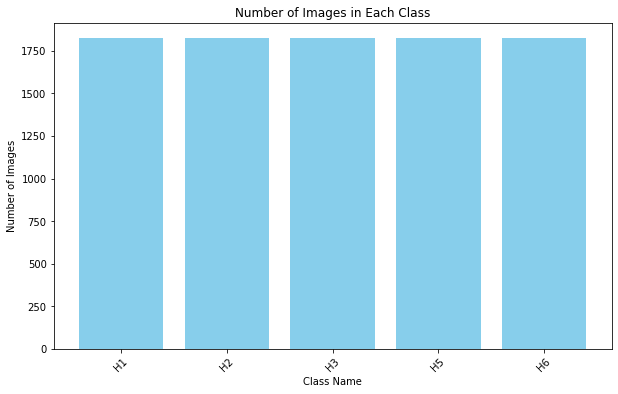

In [5]:
import matplotlib.pyplot as plt

input_folder = "defungi2"

class_names = os.listdir(input_folder)

num_images_per_class = []
for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    num_images = len(os.listdir(class_folder))
    num_images_per_class.append(num_images)

plt.figure(figsize=(10, 6))
plt.bar(class_names, num_images_per_class, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=45)
plt.show()

In [6]:
import os
import shutil
from sklearn.model_selection import train_test_split

input_folder = "defungi"
output_folder = "output"

class_names = os.listdir(input_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for class_name in class_names:
    class_folder = os.path.join(input_folder, class_name)
    output_train_folder = os.path.join(output_folder, "train", class_name)
    output_test_folder = os.path.join(output_folder, "test", class_name)
    os.makedirs(output_train_folder, exist_ok=True)
    os.makedirs(output_test_folder, exist_ok=True)

    images = os.listdir(class_folder)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    for image in train_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_train_folder, image)
        shutil.copy(src, dest)

    for image in test_images:
        src = os.path.join(class_folder, image)
        dest = os.path.join(output_test_folder, image)
        shutil.copy(src, dest)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'output/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=256,
    image_size=(256, 256),
    seed=42
)

class_names = train_dataset.class_names
class_names


Found 7290 files belonging to 5 classes.


['H1', 'H2', 'H3', 'H5', 'H6']

In [28]:
# input_folder = "/content/drive/MyDrive/Colab Notebooks/defungi"
# output = "output"

# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.80, 0.20))

In [29]:
# input_folder = "/content/drive/MyDrive/Colab Notebooks/defungi"
# output = "output"

# splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.80, 0.20))
# dataset= tf.keras.preprocessing.image_dataset_from_directory('/content/output/train')
# class_names = dataset.class_names
# class_names


# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True)

# # Define data generator without augmentation for validation
# validation_datagen = ImageDataGenerator(rescale=1./255)

In [7]:

image_size = 256

data_generator_with_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
)

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        'output/train',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

validation_generator = data_generator_no_aug.flow_from_directory(
        'output/test',
        target_size=(image_size, image_size),
        batch_size=256,
        class_mode='categorical',
        shuffle=False)

Found 7290 images belonging to 5 classes.
Found 1824 images belonging to 5 classes.


In [31]:
resnet_model = ResNet50(include_top=False,weights="imagenet")
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
res = tf.keras.layers.Dense(5, activation="softmax")(x)

model = Model(inputs=resnet_model.input, outputs=res)

for layer in resnet_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [32]:
hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1
).history

model.summary()

Epoch 1/100
29/29 [==============================] - 451s 16s/step - loss: 1.0759 - accuracy: 0.5785 - val_loss: 0.7136 - val_accuracy: 0.7089
Epoch 2/100
29/29 [==============================] - 457s 16s/step - loss: 0.6629 - accuracy: 0.7313 - val_loss: 0.6313 - val_accuracy: 0.7346
Epoch 3/100
29/29 [==============================] - 475s 16s/step - loss: 0.5855 - accuracy: 0.7668 - val_loss: 0.5757 - val_accuracy: 0.7593
Epoch 4/100
29/29 [==============================] - 478s 17s/step - loss: 0.5307 - accuracy: 0.7815 - val_loss: 0.5318 - val_accuracy: 0.7900
Epoch 5/100
29/29 [==============================] - 491s 17s/step - loss: 0.4764 - accuracy: 0.8121 - val_loss: 0.5129 - val_accuracy: 0.7889
Epoch 6/100
29/29 [==============================] - 482s 17s/step - loss: 0.4388 - accuracy: 0.8225 - val_loss: 0.4620 - val_accuracy: 0.8163
Epoch 7/100
29/29 [==============================] - 484s 17s/step - loss: 0.4051 - accuracy: 0.8425 - val_loss: 0.4619 - val_accuracy: 0.8163

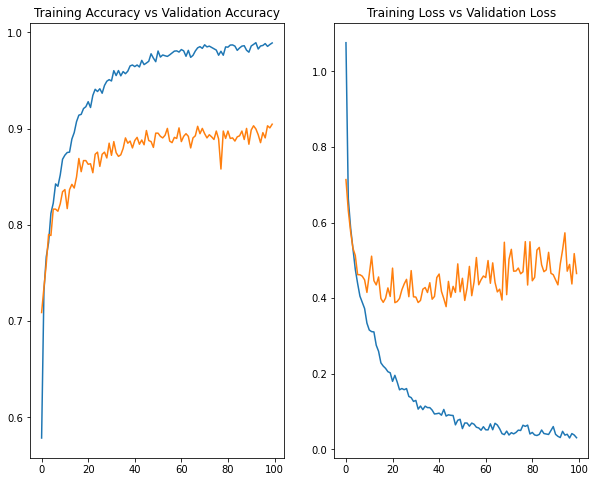

In [33]:
acc=hist['accuracy']
val_acc=hist['val_accuracy']

loss=hist['loss']
val_loss=hist['val_loss']

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.plot(range(100),acc,label='Training Accuracy')
plt.plot(range(100),val_acc,label='Validation Accuracy')
plt.title("Training Accuracy vs Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(100),loss,label='Training Loss')
plt.plot(range(100),val_loss,label='Validation Loss')
plt.title("Training Loss vs Validation Loss")
plt.show()

In [ ]:
model.save("resnet_final_256bs_100e.h5")

# Model 1

In [8]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/resnet_final_256bs_100e.h5",compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 89s 11s/step - loss: 0.6479 - accuracy: 0.7692
Test Loss: 0.647875189781189
Test Accuracy: 0.7691885828971863


In [9]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          H1       0.78      0.89      0.83       881
          H2       0.62      0.53      0.57       467
          H3       0.89      0.72      0.80       164
          H5       0.98      0.77      0.87       164
          H6       0.83      0.86      0.84       148

    accuracy                           0.77      1824
   macro avg       0.82      0.75      0.78      1824
weighted avg       0.77      0.77      0.76      1824



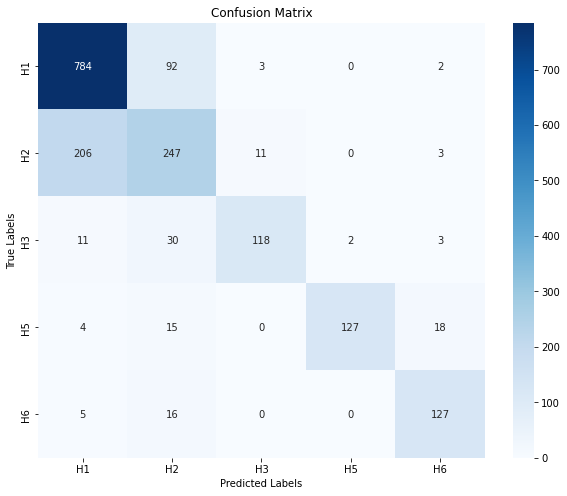

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

8/8 [==============================] - 89s 11s/step
Precision: 0.7692713512524197
Recall: 0.7691885964912281
F1-score: 0.7644860832982412


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)

Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H2


# Model 2

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/defungi-bs-32-e-100.h5",compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 89s 11s/step - loss: 0.6572 - accuracy: 0.8745
Test Loss: 0.6571922302246094
Test Accuracy: 0.874451756477356


In [12]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          H1       0.91      0.90      0.90       881
          H2       0.75      0.84      0.79       467
          H3       0.96      0.79      0.87       164
          H5       0.96      0.91      0.93       164
          H6       0.99      0.89      0.94       148

    accuracy                           0.87      1824
   macro avg       0.91      0.87      0.89      1824
weighted avg       0.88      0.87      0.88      1824



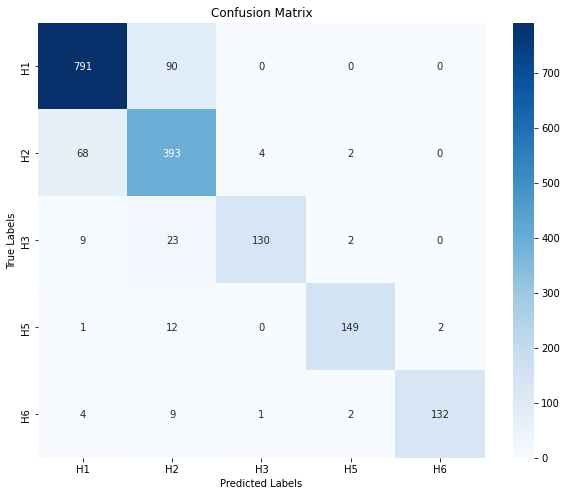

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

8/8 [==============================] - 102s 13s/step
Precision: 0.8815094949254265
Recall: 0.8744517543859649
F1-score: 0.8762341384861911


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)

Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H3


# Model 3

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf

model = tf.keras.models.load_model("models/defungi-bs-128-e-150.h5",compile=False)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0015),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=1)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 [==============================] - 91s 11s/step - loss: 0.4651 - accuracy: 0.9046
Test Loss: 0.46508902311325073
Test Accuracy: 0.9046052694320679


In [15]:
from sklearn.metrics import classification_report

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_report = classification_report(true_labels, predicted_labels, target_names=class_names)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

          H1       0.91      0.93      0.92       881
          H2       0.84      0.83      0.84       467
          H3       0.92      0.91      0.91       164
          H5       0.97      0.95      0.96       164
          H6       0.97      0.93      0.95       148

    accuracy                           0.90      1824
   macro avg       0.92      0.91      0.92      1824
weighted avg       0.90      0.90      0.90      1824



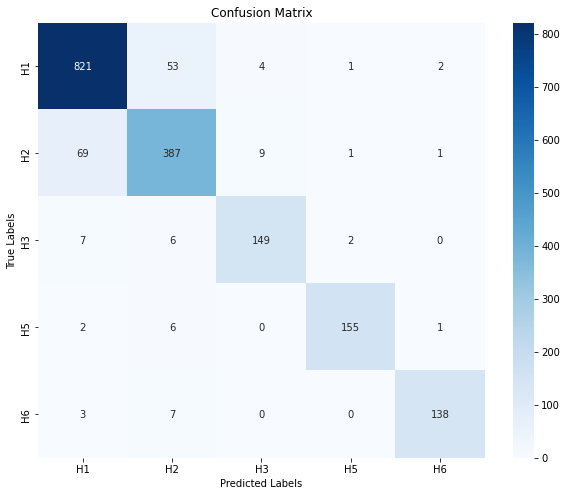

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from sklearn.metrics import precision_recall_fscore_support

predicted_probabilities = model.predict(validation_generator, verbose=1)

true_labels = []
for x, y in validation_generator:
    true_labels.extend(np.argmax(y, axis=1))
    if len(true_labels) >= len(predicted_probabilities):
        break

predicted_labels = np.argmax(predicted_probabilities, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score)

8/8 [==============================] - 93s 11s/step
Precision: 0.9047015423665924
Recall: 0.9046052631578947
F1-score: 0.904518869679394


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = preprocess_input(img_array)
    return img_array

def predict_images(model, image_paths, class_names):
    predictions = []
    for img_path in image_paths:
        img_array = load_and_preprocess_image(img_path)
        pred_probs = model.predict(img_array)
        predicted_class_index = np.argmax(pred_probs)
        predicted_class = class_names[predicted_class_index]
        predictions.append(predicted_class)
    return predictions

image_paths = ["defungi/H6/H6_2a_15.jpg","defungi/H2/H2_1a_1.jpg","defungi/H3/H3_1b_1.jpg","defungi/H5/H5_1a_1.jpg","defungi/H3/H3_2a_10.jpg"]
predicted_classes = predict_images(model, image_paths, class_names)
for i, predicted_class in enumerate(predicted_classes):
    print(f"Image {i+1} Predicted Class:", predicted_class)

Image 1 Predicted Class: H6
Image 2 Predicted Class: H2
Image 3 Predicted Class: H3
Image 4 Predicted Class: H5
Image 5 Predicted Class: H3
